# kaggle 해커톤 . 6-2조
- 프로젝트 링크:
https://www.kaggle.com/c/competitive-data-science-predict-future-sales


## team
- 6-2조
- 이상국, 강명훈, 장선우

## 일정
### 1일차
- ~ : 각자 문제 및 데이터 파악
- 11:30 ~ : data 및 문제 관련 정의 (화상)
- ~ : 각자 진행
- 14:30 ~ : 진행 과정 토의1(화상) ex) 데이터 전처리, 모델정의
- ~ : 각자 진행   
- 17:00 ~ : 진행 과정 토의2(화상) , ex) 모델평가, 그리드서치, 앙상블, 모델개선 등..
- ~ 각자 진행   
<br/><br/>

### 2일차
- 10:00 ~ : 진행과정 토의3(화상),open meet
- ~ 각자 진행   
- 11:30 ~ : 제출 전 정리 미팅, 최고 스코어 도출
- ~ 각자 진행 또는 협업
- 14:00 ~ : 최종 제출

## 대회
- 2020.08.27(목)~2020.08.28(금) PM 2:00까지
- 캐글 Public Score 중 최고점을 슬랙 대회 채널에 jupyter notebook 파일과 함께 제출
- 제출 파일은 jupyter notebook이고,
- 형식은 Exploration 노드 과제 제출 형식과 동일합니다. (결과 출력, 로그 및 주요사항 reporting)

## 문제파악


### 디스크립션
- 러시아 최대 소프트웨어 회사 중 하나 인 1C Company 에서 친절하게 제공 한 일일 판매 데이터로 구성된 까다로운 시계열 데이터 세트


### file
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

### filed 

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date_block_num==> 월 index data
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### 문제 정의
- 다음 달의 모든 제품 및 매장에 대한 총 매출을 예측

# library import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#model 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# hyper pram tuning library
from sklearn.model_selection import GridSearchCV

#time
import time

import itertools

# data import

In [2]:
# data path set

data_dir = "./data"
train_data_path = join(data_dir, 'sales_train.csv') #train data
test_data_path = join(data_dir, 'test.csv') #test data

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

categories_data_path = join(data_dir, 'item_categories.csv') #카테고리: 네임, 카테고리 아이디
items_path = join(data_dir, 'items.csv') # 아이템: 이름, id,  카테고리id
shops_path = join(data_dir, 'shops.csv') # 매장명: 매장명, id

# data import
origin_train = pd.read_csv(train_data_path)
origin_test = pd.read_csv(test_data_path)

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

# 
categories= pd.read_csv(categories_data_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shops_path)



In [3]:
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


# data 파악

In [47]:
origin_train.shape

(2935849, 6)

In [4]:
origin_train.dtypes # column data type 조회

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [5]:
origin_train.head()
# 월 정보 index column

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
origin_test.head() # test data

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
categories.head() # 카테고리 파일

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops.head() # 매장 파일

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
items.head() # 아이템 제품 파일

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
# 매장별 월별 데이터


# data preprocessing

In [4]:
##
origin_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
train = origin_train.copy()
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [40]:
test = origin_test.copy()

## 결측 데이터 숙청

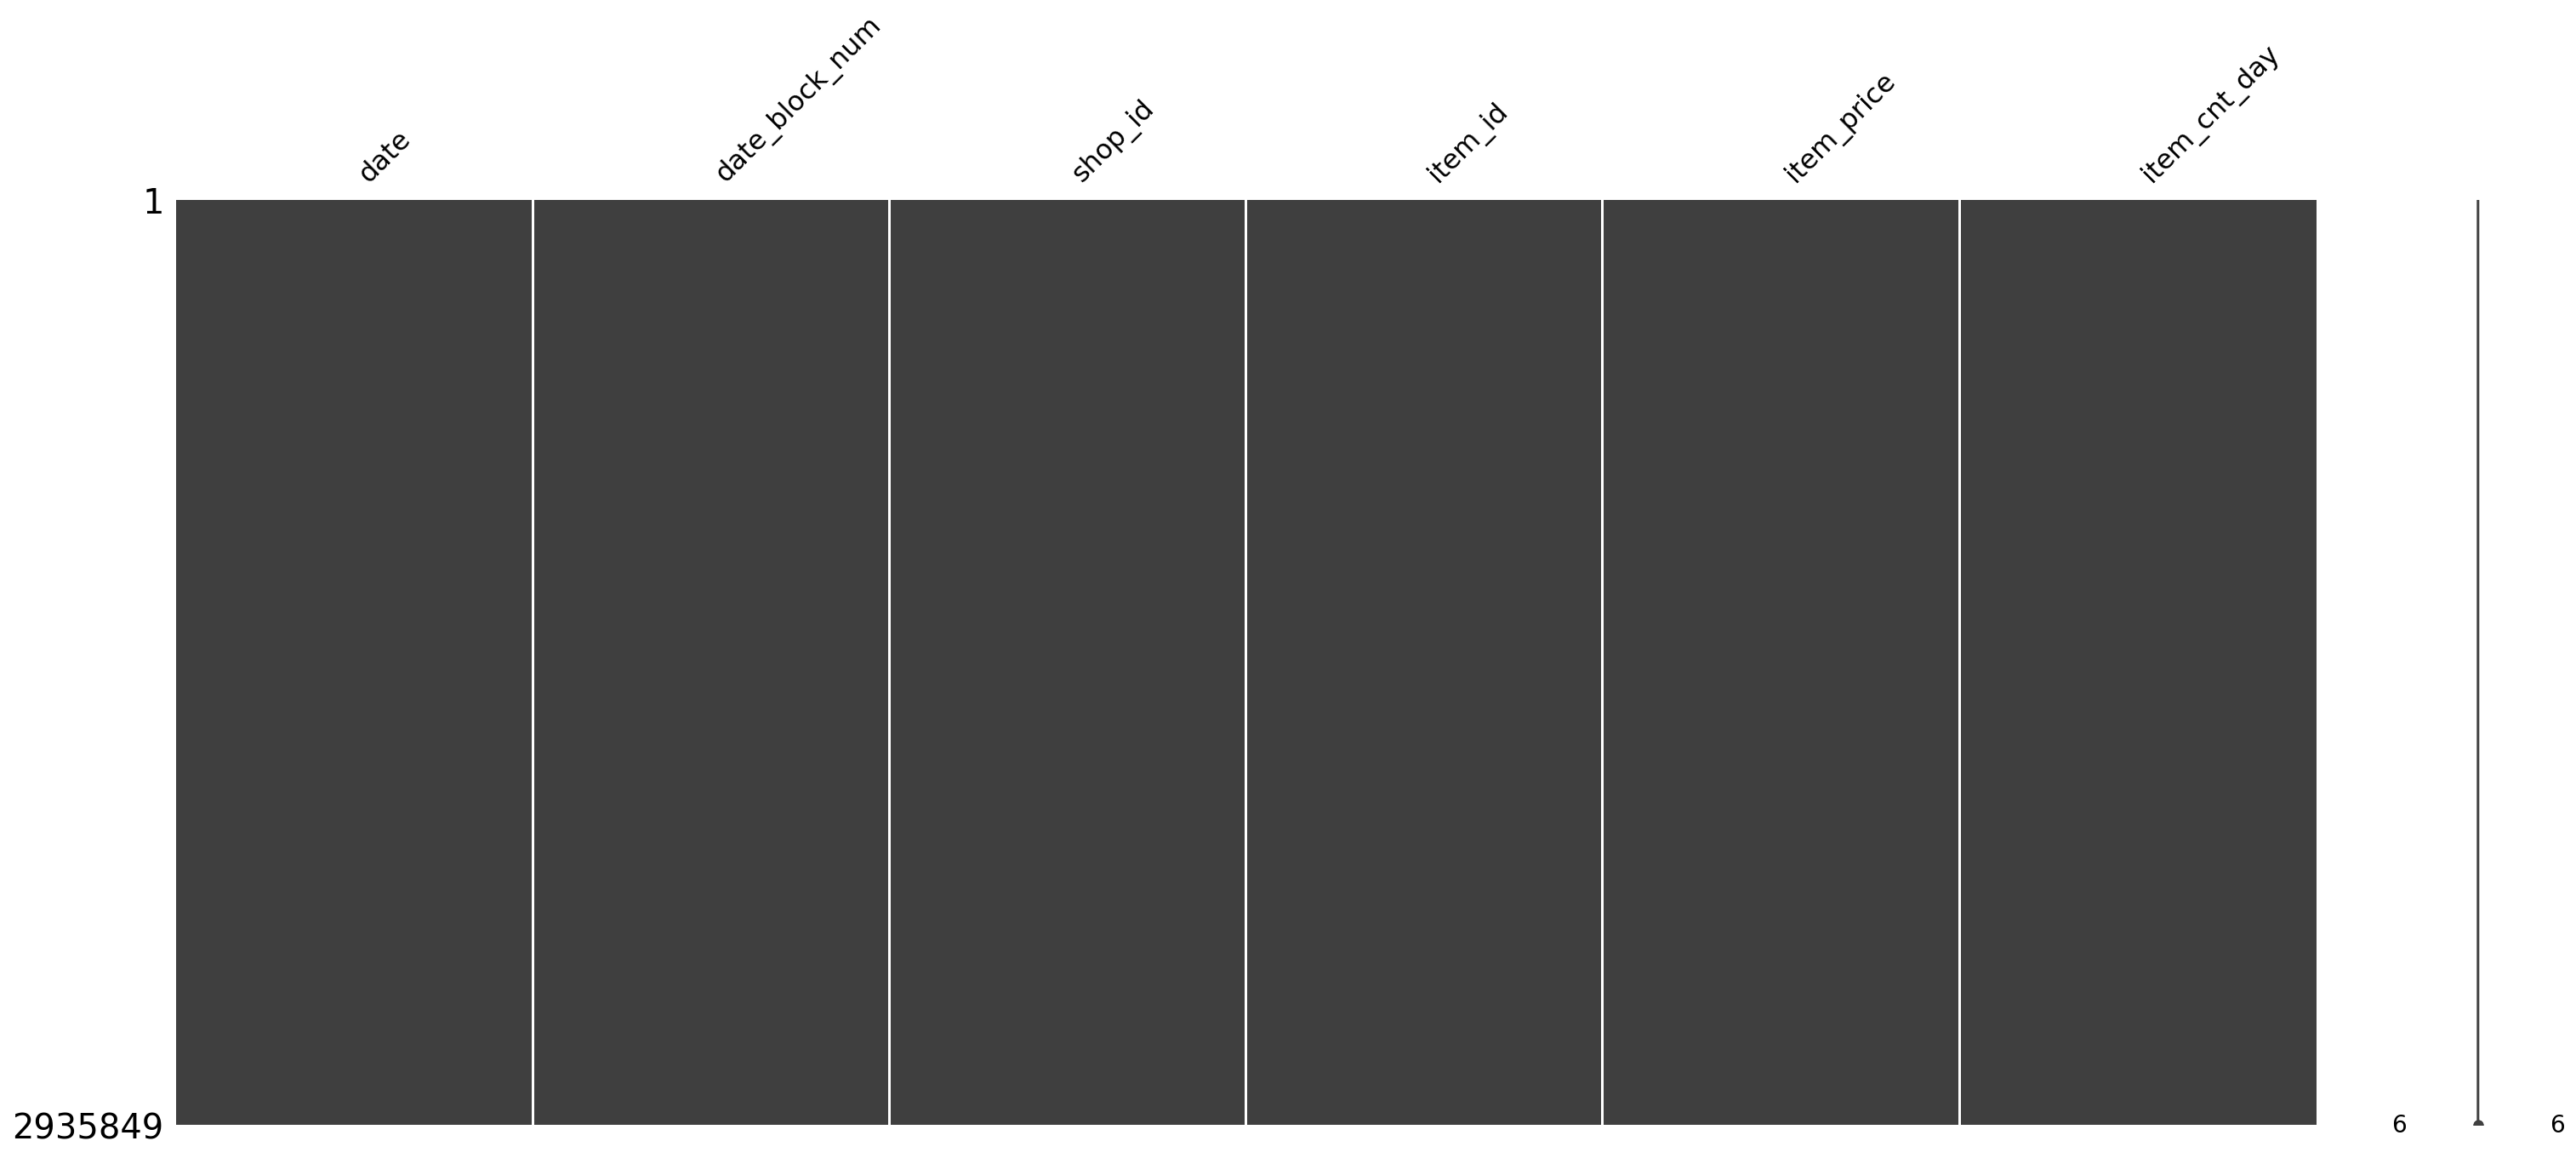

In [7]:
# 결측데이터 graph
msno.matrix(train)

In [8]:
print("------train data 결측------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
print("\n------test data 결측-------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

------train data 결측------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0

------test data 결측-------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


## 중복 데이터 숙청

In [9]:
train[train.duplicated()]
#6개 중복 데이터

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [10]:

def find_by_date_shopid_itemid(date, sid, iid):
    return train[(train['date'] == date)&(train['shop_id']==sid)&(train['item_id']==iid)]

d0 = find_by_date_shopid_itemid('05.01.2013', 54, 20130)
d1 = find_by_date_shopid_itemid('23.02.2014', 50, 3423)
d2 = find_by_date_shopid_itemid('23.03.2014', 21, 3423)
d3 = find_by_date_shopid_itemid('01.05.2014', 50, 3423)
d4 = find_by_date_shopid_itemid('12.07.2014', 25, 3423)
d5 = find_by_date_shopid_itemid('31.12.2014', 42, 21619)
print (d0)
print (d1)
print (d2)
print (d3)
print (d4)

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day
76961  05.01.2013               0       54    20130       149.0           1.0
76962  05.01.2013               0       54    20130       149.0           1.0
               date  date_block_num  shop_id  item_id  item_price  \
1435365  23.02.2014              13       50     3423       999.0   
1435367  23.02.2014              13       50     3423       999.0   

         item_cnt_day  
1435365           1.0  
1435367           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1496765  23.03.2014              14       21     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   

         item_cnt_day  
1496765           1.0  
1496766           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1671872  01.05.2014              16       50     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   

In [11]:
#중복 데이터 숙청.
train.drop_duplicates(inplace=True)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 이상치

### cnt_day , price

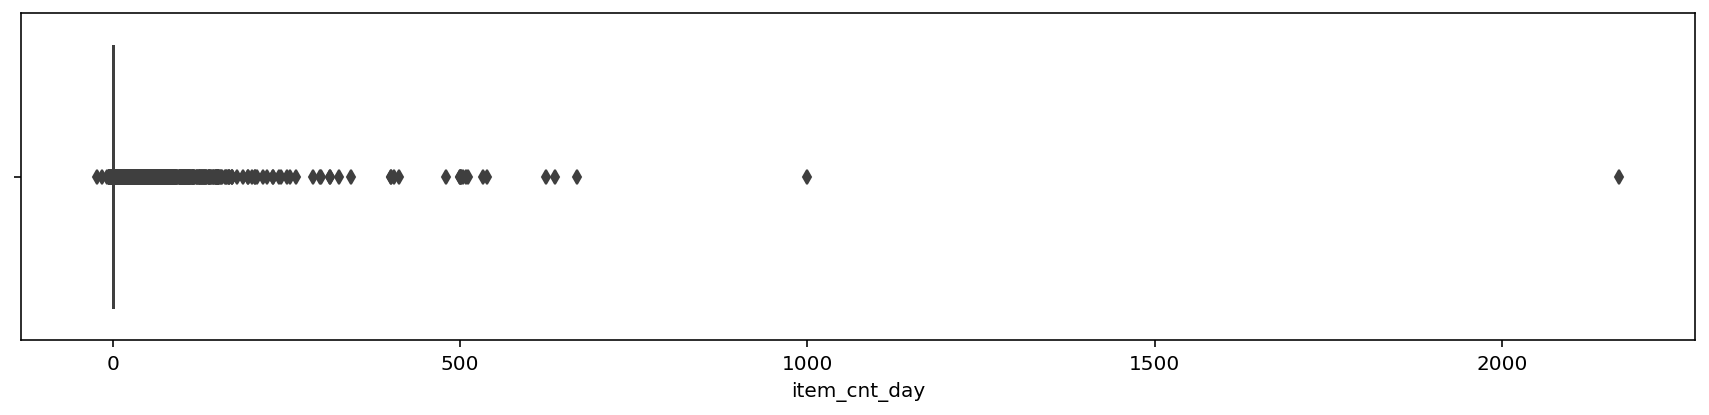

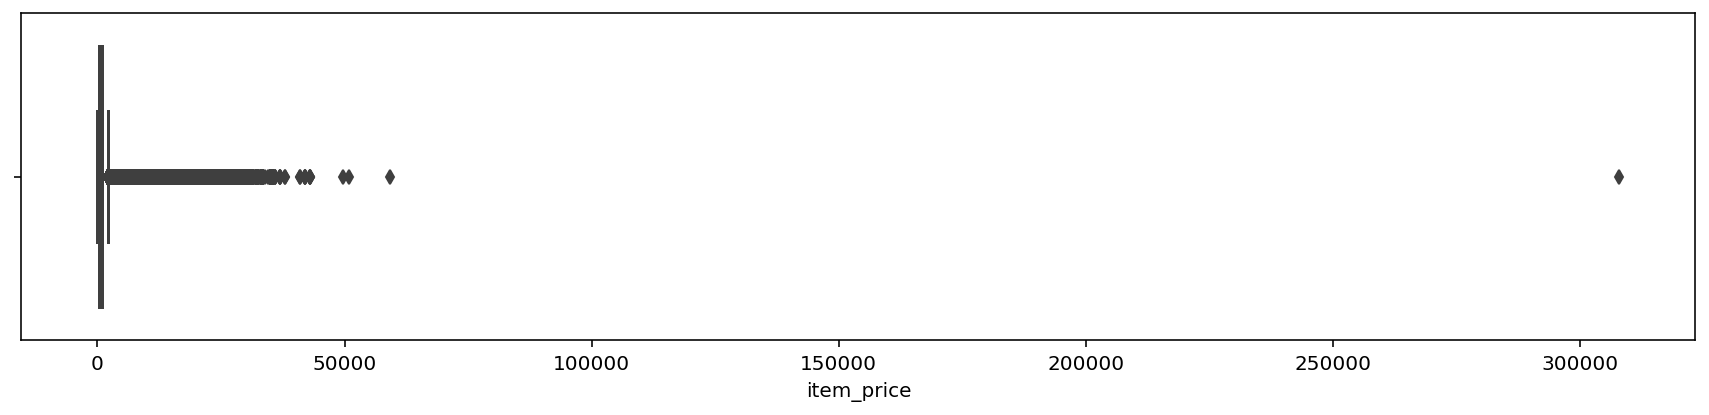

In [12]:
# 개수와 가격

plt.figure(figsize=(15,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(15,3))
sns.boxplot(x='item_price', data=train);


In [13]:
# 이상치 제거
train = train[train.item_cnt_day < 600]
train = train[train.item_price < 50000]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


### data standardization 
 - 한 번에 요약된 통계 결과를 반환, 시리즈 혹은 데이터프레임의 각 열에 대한 요약 통계 

In [15]:
# data standardization
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935835e+06,2.935835e+06,2.935835e+06,2.935835e+06,2.935835e+06
mean,1.456989e+01,3.300175e+01,1.019723e+04,8.907117e+02,1.240907e+00
std,9.422982e+00,1.622696e+01,6.324296e+03,1.719908e+03,2.120441e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,5.390000e+02


### cnt_day 마이너스 데이터 처리(미적용)

- item_cnt_day < 0

In [14]:
train[train["item_cnt_day"] < 0] # -data 조회

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [15]:
# price 가 0 미만인 이상값 확인 (미적용)
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [16]:
# 전 기간의 가격들 중 중간 값으로 바꿔줌
median = train[train.shop_id==32].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

## 매출 데이터 생성(일 별)
- 가격 * 아이템 수

In [18]:
train['sales_day'] = train['item_price'] * train['item_cnt_day']
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,299.00
2935845,09.10.2015,33,25,7460,299.00,1.0,299.00
2935846,14.10.2015,33,25,7459,349.00,1.0,349.00
2935847,22.10.2015,33,25,7440,299.00,1.0,299.00


## 불필요 데이터 숙청
- date 의 날짜 제외

In [66]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [20]:
D_train = train.drop(['date','item_price','item_cnt_day'], axis=1, inplace=False)
D_train

,date_block_num,shop_id,item_id,sales_day
0,0,59,22154,999.00
1,0,25,2552,899.00
2,0,25,2552,-899.00
3,0,25,2554,1709.05
4,0,25,2555,1099.00
...,...,...,...,...
2935844,33,25,7409,299.00
2935845,33,25,7460,299.00
2935846,33,25,7459,349.00
2935847,33,25,7440,299.00


## 월별 데이터로 그룹
- 매장별 아이템합 , 월별 그룹핑

In [21]:
# 그룹핑
G_train = D_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg('sum')

G_train.reset_index(inplace=True) # indexing
G_train = G_train.rename({'sales_day':'sales_month'}, axis='columns') # column 명 변경
G_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'sales_month'], dtype='object')

In [22]:
G_train.dtypes

date_block_num      int64
shop_id             int64
item_id             int64
sales_month       float64
dtype: object

In [23]:
G_train[G_train['shop_id'] == 0]

,date_block_num,shop_id,item_id,sales_month
0,0,0,32,1326.0
1,0,0,33,1041.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,257.0
...,...,...,...,...
65655,1,0,22138,188.0
65656,1,0,22139,624.0
65657,1,0,22151,2144.0
65658,1,0,22154,1314.0


## 시계열 데이터 처리

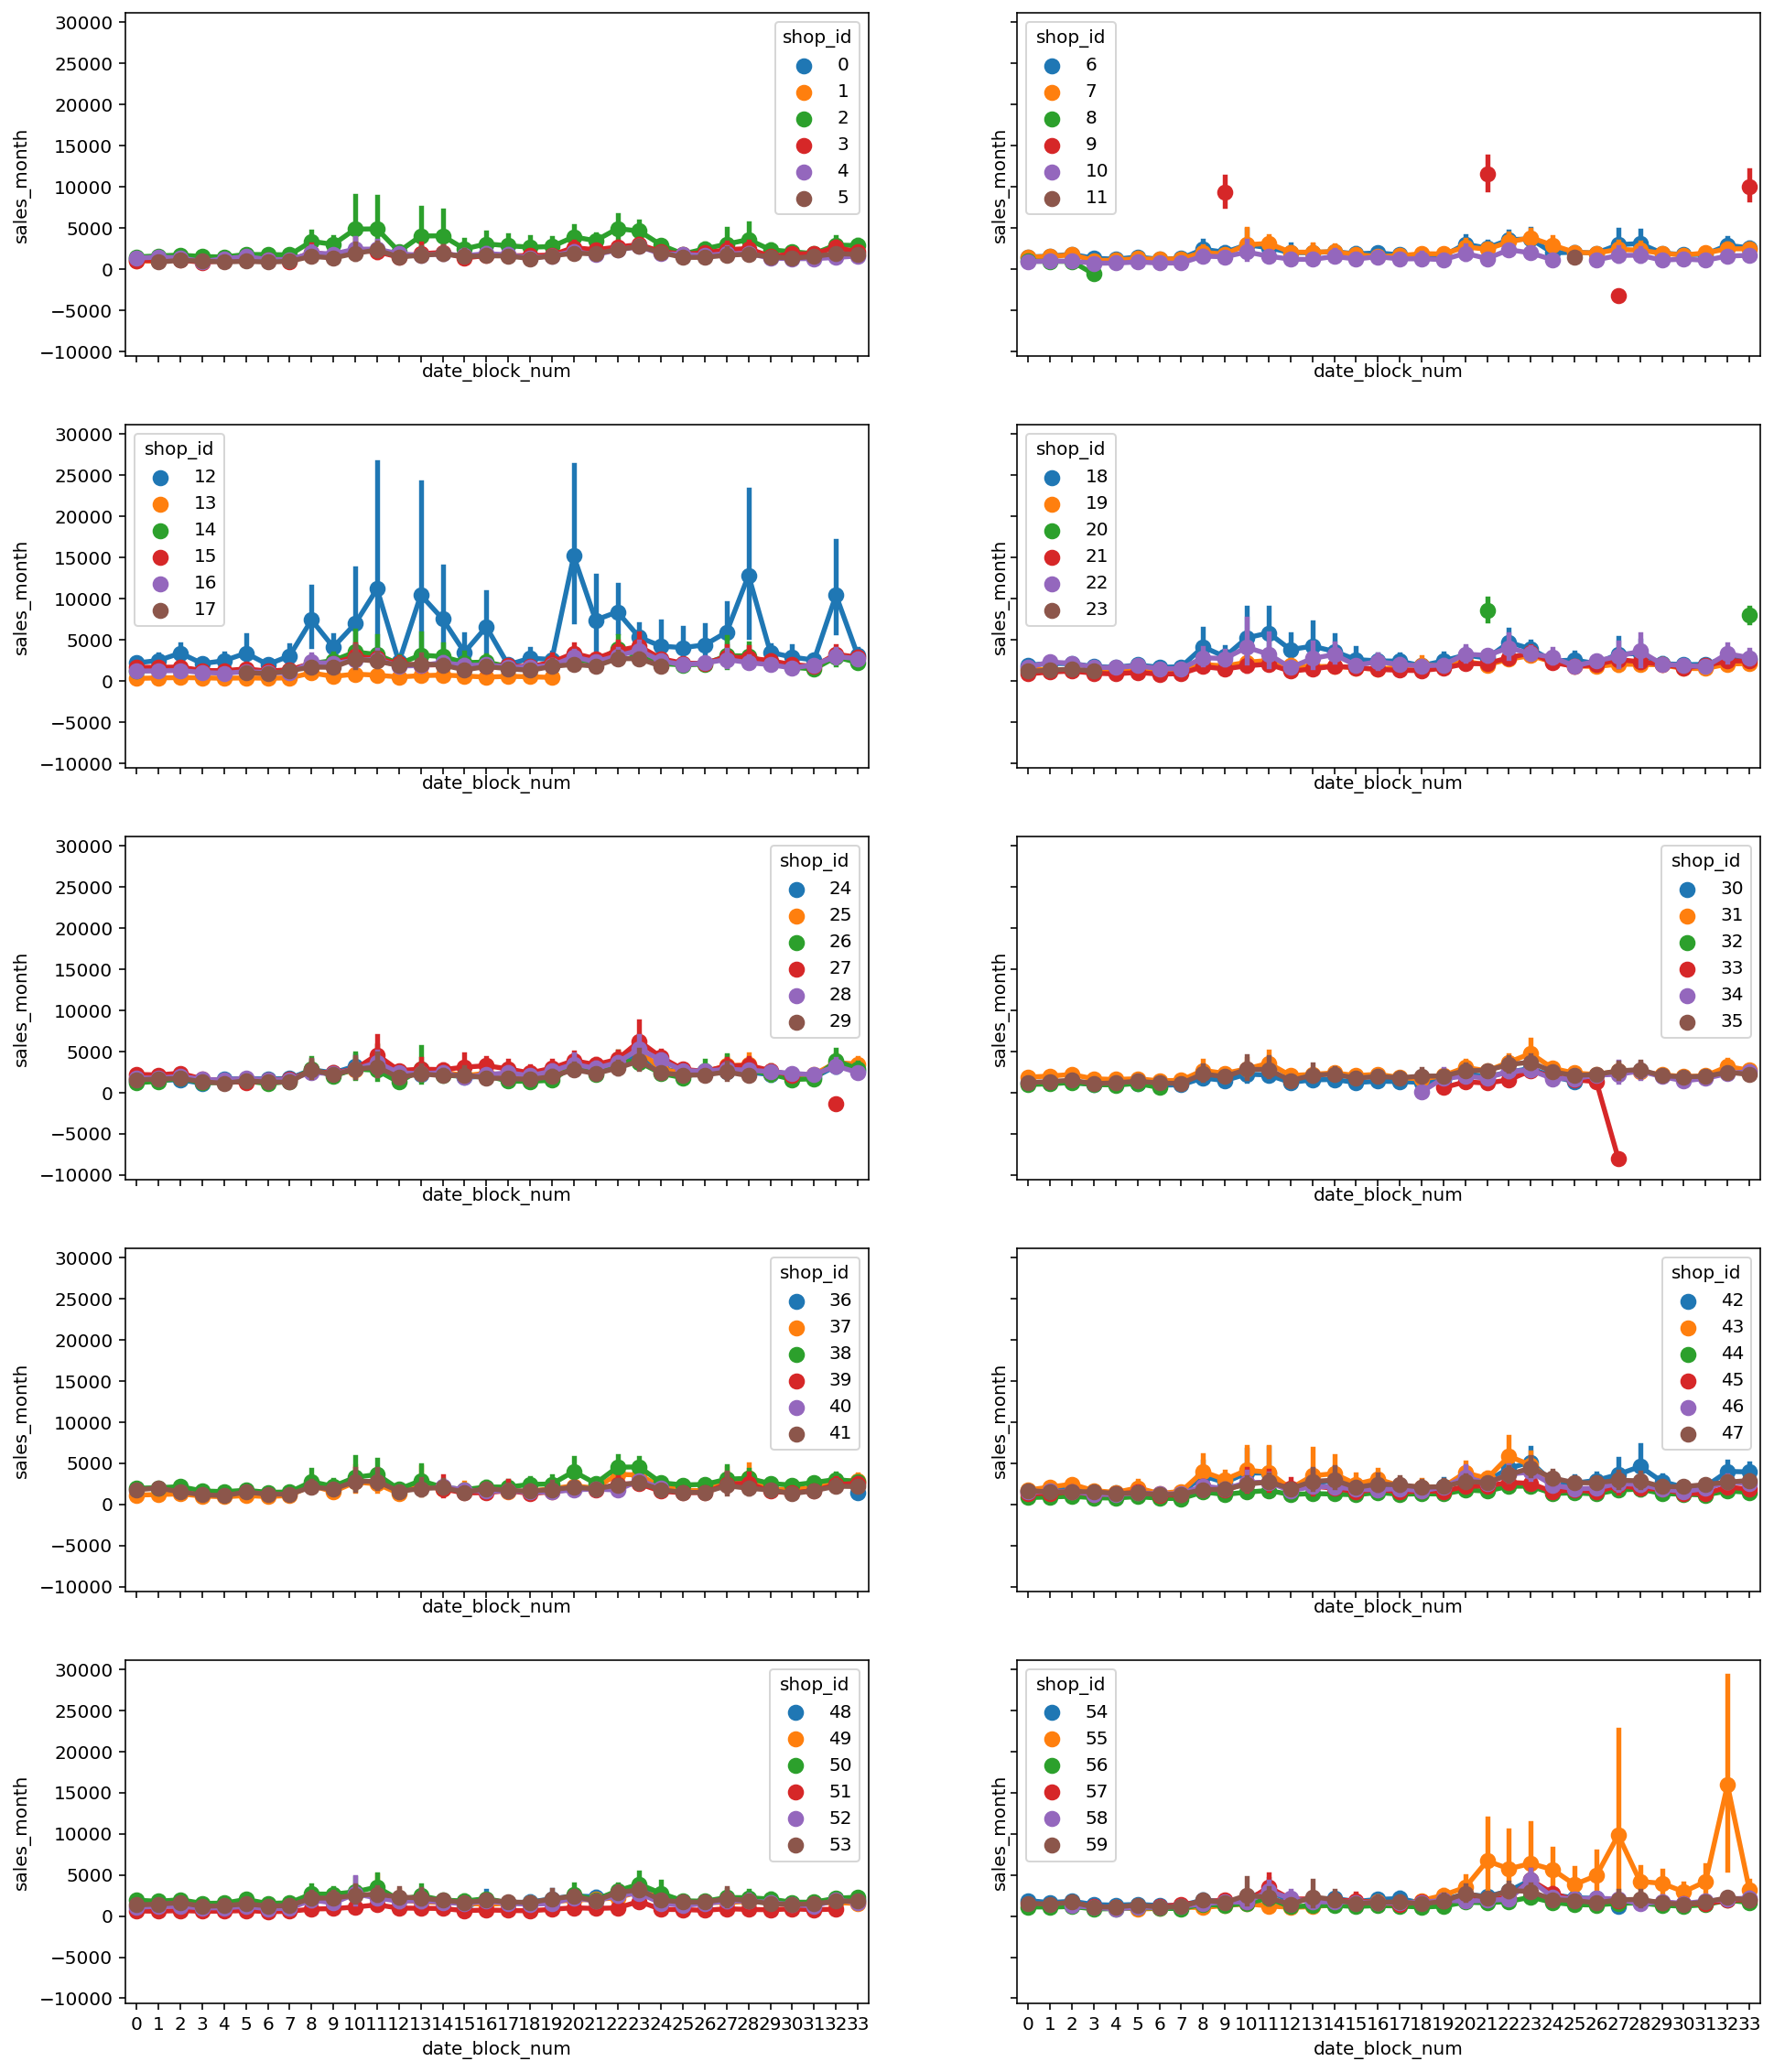

In [24]:
import math
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = math.ceil(G_train.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='sales_month', hue='shop_id', data=G_train[np.logical_and(count*id_per_graph <= G_train['shop_id'], G_train['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

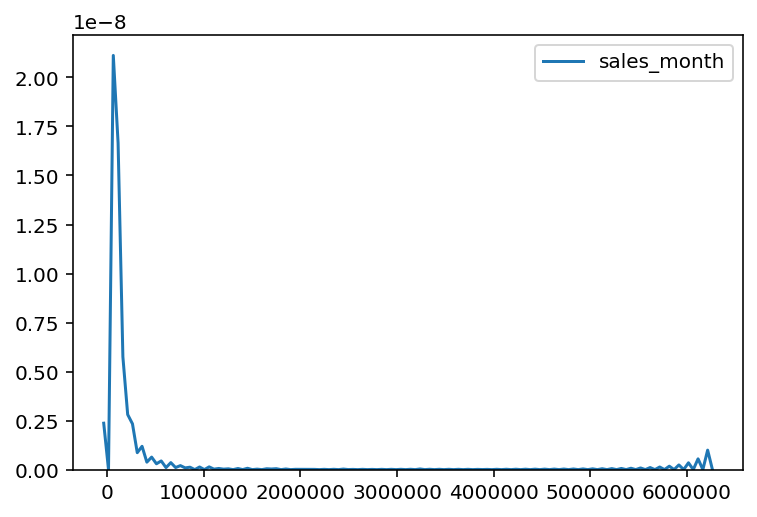

In [25]:
sns.kdeplot(G_train['sales_month'])
plt.show()

In [26]:
skew_columns = ['sales_month', 'date_block_num', 'shop_id', 'item_id']

for c in skew_columns:
    G_train[c] = np.log1p(G_train[c].values)

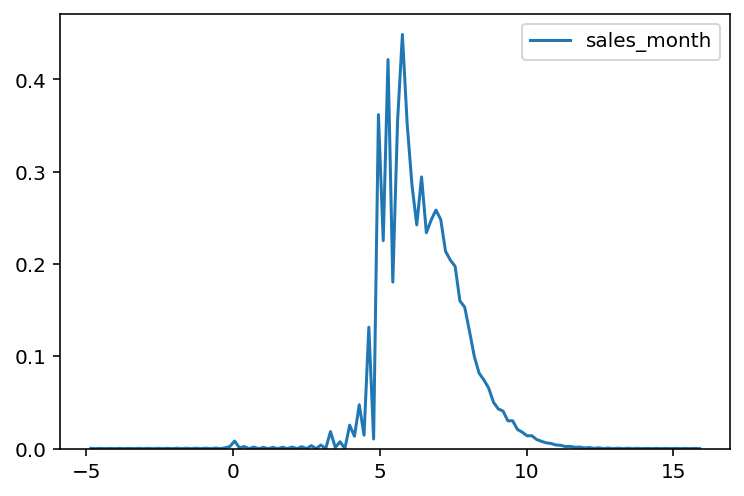

In [27]:
# sales_month 로그 시각화: 정규 분포에 가까워짐

sns.kdeplot(G_train[skew_columns[0]])


## x train data 정리
- 매장별
- 월별
- 매출 : 판매수 * 가격

In [28]:
# 모든 경우의 월, 상점, 상품 고려한 데이터 프레임 생성
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [29]:

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group['sales_month'] = group['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['sales_month'] = (matrix['sales_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [61]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month_x,item_cnt_month_y,item_cnt_month,sales_month
0,0,0,19,0.0,NaN,NaN,0.0
1,0,0,27,0.0,NaN,NaN,0.0
2,0,0,28,0.0,NaN,NaN,0.0
3,0,0,29,0.0,NaN,NaN,0.0
4,0,0,32,6.0,6.0,6.0,6.0
...,...,...,...,...,...,...,...
10913751,33,59,22162,0.0,NaN,NaN,0.0
10913752,33,59,22163,0.0,NaN,NaN,0.0
10913753,33,59,22164,0.0,NaN,NaN,0.0
10913754,33,59,22166,0.0,NaN,NaN,0.0


In [30]:
matrix['sales_month'] = matrix['sales_month'].fillna(0).clip(0, 30).astype(np.float16)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,sales_month
0,0,0,19,NaN,0.0
1,0,0,27,NaN,0.0
2,0,0,28,NaN,0.0
3,0,0,29,NaN,0.0
4,0,0,32,6.0,6.0


In [31]:
matrix = pd.concat([matrix, origin_test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,sales_month,ID
0,0.0,0,19,0.0,0.0,0.0
1,0.0,0,27,0.0,0.0,0.0
2,0.0,0,28,0.0,0.0,0.0
3,0.0,0,29,0.0,0.0,0.0
4,0.0,0,32,6.0,6.0,0.0


In [41]:
# # matrix에 df_shops, df_items, df_item_categories merge

# matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
# matrix = pd.merge(matrix, items, on=['item_id'], how='left')
# matrix = pd.merge(matrix, categories, on=['item_category_id'], how='left')

# matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,sales_month,ID,shop_name,item_name,item_category_id,item_category_name
0,0.0,0,19,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
1,0.0,0,27,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PS3, русская версия]",19,Игры - PS3
2,0.0,0,28,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания
3,0.0,0,29,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360
4,0.0,0,32,6.0,30.0,0.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD


## y값 처리
- train 에서 y 값 도려내기
- y 값 분포 조정

In [32]:
# def lag_feature(train, lags, col):
#     tmp = train[['date_block_num','shop_id','item_id',col]]
#     for i in lags:
#         shifted = tmp.copy()
#         shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
#         shifted['date_block_num'] += i
#         train = pd.merge(train, shifted, on=['date_block_num','shop_id','item_id'], how='left')
#     return train

In [ ]:
## 

## RMSE 계산

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


# model 

In [44]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]



In [45]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [47]:
df = {}
y = test.copy()
train = matrix
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

ValueError: Found input variables with inconsistent numbers of samples: [11127956, 214200]

In [49]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [50]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [36]:
get_cv_score(models)

NameError: name 'x' is not defined

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

In [ ]:
data_dir = os.getenv('HOME')+'/workplace/aiffel/Exploration/Hackathon/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:

result = pd.DataFrame({
    'id' : sub_id, 
    'item_cnt_month' : y_pred
})

result.head()

In [ ]:

result.to_csv(submission_path, index=False)

print(my_submission_path)

# reference

- https://github.com/BaekKyunShin/Kaggle/blob/master/Predict_Future_Sales/Predict%20Future%20Sales.ipynb

- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

# test

In [ ]:
origin_train.tail()

# comment